# Generating Images of Digits from Text Prompts

This notebook provides you with a complete code example to generate MNIST digits from text prompts. The `train_text_prompts.txt` and `test_text_prompts.txt` files provide the text data used for training and testing.

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [1]:
from torchvision.transforms import Compose, Normalize, ToTensor

trans = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5], inplace=True)])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=trans, download=True)

... and plot some of the transformed MNIST digits.

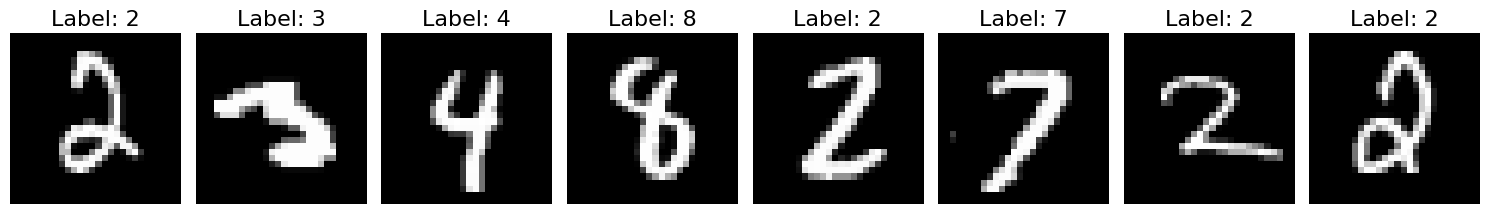

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process

Define the device on which the computations are performed ...

In [4]:
import torch

def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    # elif torch.backends.mps.is_available():
    #    return torch.device("mps")
    else:
        return torch.device("cpu")

In [5]:
device = get_device()

In [6]:
print(device)

mps


... implement the forward diffusion process ...

In [7]:
class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.noise_steps, self.beta_start, self.beta_end, self.device = \
            noise_steps, beta_start, beta_end, device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [8]:
diffusion = Diffusion(noise_steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]
noisy_images = []
for i in range(len(time_steps)):
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), 
        t=torch.tensor([time_steps[i]]).to(device)
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

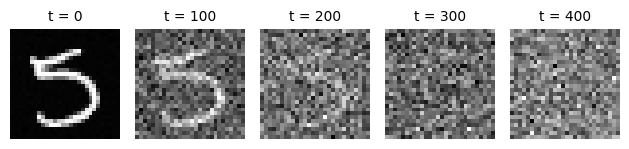

In [9]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {time_steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [10]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps, self.beta_start, self.beta_end, self.device = \
            noise_steps, beta_start, beta_end, device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        self.img_size = img_size

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels, 
                          position_encoding_dim, position_encoding_function,
                          fix_noise=None, save_time_steps=None, 
                          context=None, guidance_strength=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                ).to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                if context is None:
                    predicted_noise = model(x=x, t=t_pos_enc)
                else:
                    conditional_pred = model(x=x, t=t_pos_enc, context=context)
                    unconditional_pred = model(x=x, t=t_pos_enc, context=None)
                    predicted_noise = torch.lerp(unconditional_pred,
                                                 conditional_pred,
                                                 guidance_strength)

                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Preparing the Text Prompts

Load the text prompts ...

In [11]:
train_text_prompts = []
with open("train_text_prompts.txt", "r") as f:
    for line in f: train_text_prompts.append(line.strip())

test_text_prompts = []
with open("test_text_prompts.txt", "r") as f:
    for line in f: test_text_prompts.append(line.strip())

In [12]:
for text_prompt in train_text_prompts: print(text_prompt)

Generate the digit {class_label}.
Create a sample of the number {class_label}.
Show me a picture of the digit {class_label}.
Produce the handwritten digit {class_label}.
Please generate a grayscale image of the number {class_label}.
Kindly create the digit {class_label} in a 28x28 resolution.
I'd like to see the number {class_label} in bold font style.
Show me the digit {class_label} in a slanted appearance.
Generate the digit {class_label} with smooth curves.
Create the number {class_label} with sharp edges.
Show me an enhanced image of the digit {class_label}.
Generate a blurry version of the digit {class_label}.
Create an artistic representation of the number {class_label}.
Show me the digit {class_label} as if drawn by a child.
Generate the digit {class_label} with a serif font style.
Create the number {class_label} with consistent stroke thickness.
Show me the digit {class_label} in a tilted orientation.
Generate the digit {class_label} with added noise.
Create the number {class_l

In [13]:
for text_prompt in test_text_prompts: print(text_prompt)

{class_label} individuals are attending a play in a theater that seats eight. How many people are in the theater?
There are six types of flowers in the garden, and {class_label} are roses. How many flowers are roses?
{class_label} students passed the math test out of nine who took it. How many students succeeded?
In a parking lot, {class_label} out of eight vehicles are vans. How many vans are parked?
During a survey, {class_label} out of nine respondents said they enjoy gardening. How many participants enjoy gardening?
A chef makes nine dishes, and {class_label} are vegetarian. How many dishes are vegetarian?
Eight people finished their tasks, and {class_label} were volunteers. How many volunteers completed their tasks?
A group of tourists visits a national park, and {class_label} of them are seniors. How many seniors are visiting?
{class_label} out of nine poets read their poems live. How many poets read their poems?
Out of nine players, {class_label} play chess. How many chess playe

... implement a function to generate text prompts from given class labels ...

In [14]:
import inflect, random

numbers = {i: inflect.engine().number_to_words(i) for i in range(10)}

def generate_text_prompts(class_labels, text_inputs):
    """Generate text prompts."""
    texts = []
    for i in class_labels:
        if random.random() > 0.3:
            prompt = random.choice(text_inputs).format(class_label=numbers[i])
        else:
            prompt = random.choice(text_inputs).format(class_label=str(i))
        texts.append(prompt)
    return texts

... and generate and print some example text prompts.

In [15]:
class_labels = random.sample(list(range(10)), 4)
example_text_prompts = generate_text_prompts(class_labels, test_text_prompts)
for text_prompt in example_text_prompts: print(text_prompt)

Show me a grayscale rendering of a 5.
Design a three with artistic accents.
zero rabbits are playing in the garden, while four are resting. How many rabbits are active?
Showcase a realistic depiction of a 7.


## Defining the Position Encoding Function

Implement the position encoding function ...

In [16]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    x = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_a, pos_enc_b = torch.sin(x), torch.cos(x)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [17]:
position_encoding_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, position_encoding_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

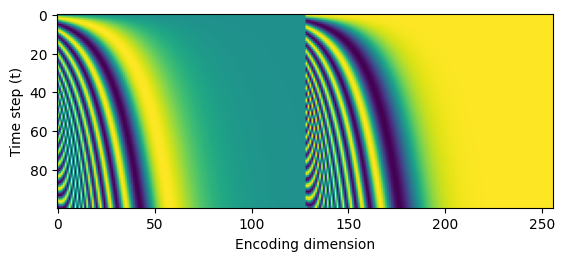

In [18]:
fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.show()

## Defining a Custom Tokenizer and Text Encoder

Implement the function to tokenize the text ...

In [19]:
import spacy
import re
import contractions
import unicodedata
from spacy.symbols import ORTH

tokenizers = {
    "eng": spacy.blank("en"),
    "spa": spacy.blank("es")
}

# Add special cases to both tokenizers
special_cases = ["!!!", "??", "!!", "?!", "!?", "???"]
for case in special_cases:
    for lang in tokenizers:
        tokenizers[lang].tokenizer.add_special_case(case, [{ORTH: case}])

# Regex for monetary values (USD, GBP, EUR)
monetary_pattern = r'((\$|£|€)\d+(\.\d{1,2})?|\d+(\.\d{1,2})?(\$|£|€))'

# Define the verbose pattern to enforce stricter token matching
verbose_pattern = re.compile(
    unicodedata.normalize("NFC", r"""
    ^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿/:()$£€]+  # 1+ allowed characters.
    (-[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿/:()$£€]+)*  # Optional hyphen plus chars.
    (_[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿/:()$£€]+)*  # Optional underscore plus chars.
    $  # End of the string.
    """), re.VERBOSE
)

def replace_with_placeholder(text, pattern, placeholder_map):
    """Replace matches with placeholders and track replacements."""
    def replacer(match):
        placeholder = f"PLACEHOLDER{len(placeholder_map)}"
        placeholder_map[placeholder] = match.group(0)
        return placeholder
    return re.sub(pattern, replacer, text)

def tokenize(text, lang="eng"):
    """Tokenize text with SpaCy, preserving monetary values and applying filters."""

    # Standardize text replacements (apostrophes, quotes)
    replacements = {"’": "'", "‘": "'", "“": '"', "”": '"', "´": "'", "´´": '"'}
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Replace special characters and expand contractions for English
    text = contractions.fix(text) if lang == "eng" else text

    # Replace monetary values with placeholders
    placeholder_map = {}
    text = replace_with_placeholder(text, monetary_pattern, placeholder_map)

    # Tokenize the text with SpaCy
    tokens = tokenizers[lang](text)

    # Apply verbose pattern to filter tokens
    filtered_tokens = [
        placeholder_map.get(token.text, token.text)  # Restore placeholders if any
        for token in tokens if verbose_pattern.match(token.text)
    ]
    
    return filtered_tokens


In [20]:
class Vocab:
    """Wrapper around a dictionary to make it callable like torchtext's Vocab."""
    def __init__(self, vocab_dict, unk_token="<unk>"):
        self.vocab_dict = vocab_dict
        self.unk_token = unk_token
        self.default_index = vocab_dict.get(unk_token, -1)
        self.index_to_token = {idx: token for token, idx in vocab_dict.items()}
        
    def __call__(self, token_or_tokens):
        """Make the vocab callable to return the index for a given token or list of tokens."""
        if isinstance(token_or_tokens, list):
            return [self.vocab_dict.get(token, self.default_index) for token in token_or_tokens]
        return self.vocab_dict.get(token_or_tokens, self.default_index)
    
    def set_default_index(self, index):
        """Set default index for unknown tokens."""
        self.default_index = index

    def lookup_token(self, index_or_indices):
        """Retrieve the token corresponding to a given index or list of indices."""
        if isinstance(index_or_indices, list):
            return [self.index_to_token.get(int(index), self.unk_token) for index in index_or_indices]
        return self.index_to_token.get(int(index_or_indices), self.unk_token)

    def get_itos(self):
        """Return a list of tokens ordered by their index."""
        itos = [None] * len(self.index_to_token)
        for index, token in self.index_to_token.items():
            itos[index] = token
        return itos
        
    def __iter__(self):
        """Iterate over the tokens in the vocabulary."""
        return iter(self.vocab_dict)

    def __len__(self):
        """Return the number of tokens in the vocabulary."""
        return len(self.vocab_dict)
    
    def __contains__(self, token):
        """Check if a token is in the vocabulary."""
        return token in self.vocab_dict


In [21]:
from collections import Counter

def build_vocab_from_iterator(iterator, specials=None, min_freq=1):
    """Build vocabulary from an iterator over tokenized sentences."""
    # Count the frequency of each token
    counter = Counter(token for tokens in iterator for token in tokens)

    # Initialize the vocabulary with special tokens
    vocab = {}
    index = 0

    if specials:
        for token in specials:
            vocab[token] = index
            index += 1

    # Add tokens that meet the minimum frequency
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = index
            index += 1

    return vocab

... build a custom vocabulary ...

In [22]:
def token_iterator(texts):
    """Iterate on tokens."""
    for text in texts:
        yield tokenize(text)

digits_and_words = [str(item) for item in list(numbers.keys()) 
                    + list(numbers.values())]

vocab_dict = build_vocab_from_iterator(
    token_iterator(train_text_prompts + test_text_prompts + digits_and_words),
    specials=["<unk>", "<sos>", "<eos>", "<pad>"],
) 

vocab = Vocab(vocab_dict, unk_token="<unk>")
vocab.set_default_index(vocab(vocab.unk_token))

... check the vocabulary and string-to-numerical indices mapping ...

In [23]:
for word, index in vocab_dict.items(): print(f"{word}: {index}")

<unk>: 0
<sos>: 1
<eos>: 2
<pad>: 3
Generate: 4
the: 5
digit: 6
class_label: 7
.: 8
Create: 9
a: 10
sample: 11
of: 12
number: 13
Show: 14
me: 15
picture: 16
Produce: 17
handwritten: 18
Please: 19
generate: 20
grayscale: 21
image: 22
Kindly: 23
create: 24
in: 25
28x28: 26
resolution: 27
I: 28
would: 29
like: 30
to: 31
see: 32
bold: 33
font: 34
style: 35
slanted: 36
appearance: 37
with: 38
smooth: 39
curves: 40
sharp: 41
edges: 42
an: 43
enhanced: 44
blurry: 45
version: 46
artistic: 47
representation: 48
as: 49
if: 50
drawn: 51
by: 52
child: 53
serif: 54
consistent: 55
stroke: 56
thickness: 57
tilted: 58
orientation: 59
added: 60
noise: 61
using: 62
minimal: 63
strokes: 64
cursive: 65
sketch: 66
drawing: 67
textured: 68
background: 69
monospaced: 70
simple: 71
elegant: 72
embellishments: 73
precise: 74
symmetry: 75
modern: 76
futuristic: 77
intricate: 78
details: 79
retro: 80
distortions: 81
shadow: 82
effect: 83
vibrant: 84
colors: 85
3D: 86
calligraphy: 87
embossed: 88
features: 89
pix

... write a function to implemet a function to pad and process ...

In [24]:
def pad_and_process(texts, vocab=vocab, max_token_length=77):
    """Tokenize a sentence."""
    batch_tokens = []
    for text_prompt in texts:
        tokens = ([vocab("<sos>")] + 
                  [vocab(token) for token in tokenize(text_prompt)] + 
                  [vocab("<eos>")])

        if len(tokens) > max_token_length:
            tokens = tokens[:max_token_length]
        else:
            tokens += [vocab("<pad>")] * (max_token_length - len(tokens))
        
        tokens = torch.tensor(tokens, dtype=torch.long)
        batch_tokens.append(tokens)
    return torch.stack(batch_tokens)

... observe a tokenized version of an example text prompt ...

In [25]:
class_labels = random.sample(list(range(10)), 1)
example_text = generate_text_prompts(class_labels, train_text_prompts)
tokens = pad_and_process(example_text)
print(example_text), print(tokens.shape), print(tokens);

['Four artists display their paintings, and 6 sell theirs. How many painters sold their work?']
torch.Size([1, 77])
tensor([[  1, 250, 274, 275, 276, 277, 131, 132, 450, 278, 279,   8, 122, 123,
         280, 281, 276, 258, 125,   2,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3]])


... implement a class for a custom text encoder ...

In [26]:
import torch.nn as nn

class TextEncoder(nn.Module):
    """Text encoder."""

    def __init__(self, max_token_length, vocab_size, embedding_dim, num_heads):
        """Initialize the text encoder module."""
        super(TextEncoder, self).__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_encoding = positional_encoding(
            torch.arange(0, max_token_length).unsqueeze(1), embedding_dim,
        )

        self.self_attention = nn.MultiheadAttention(
            embedding_dim, num_heads=num_heads, batch_first=True,
        )
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim), nn.GELU(),
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, tokens):
        """Forward pass of text encoder module."""
        token_embeddings = self.token_embedding(tokens)
        position_encodings = (self.position_encoding
                              .repeat(tokens.size(0), 1, 1).to(tokens.device))

        token_embeddings_with_pos = token_embeddings + position_encodings

        normalized_embeddings = self.layer_norm1(token_embeddings_with_pos)
        attention_output, _ = self.self_attention(
            query=normalized_embeddings, 
            key=normalized_embeddings, 
            value= normalized_embeddings,
        )
        attention_output = attention_output + normalized_embeddings

        residual_input = attention_output
        normalized_attention_output = self.layer_norm2(attention_output)
        feed_forward_output = self.feed_forward(normalized_attention_output)
        residual_output = feed_forward_output + residual_input

        return residual_output

... instantiate a custom text encoder ...

In [27]:
custom_text_encoder = TextEncoder(max_token_length=77, vocab_size=len(vocab),
                                  embedding_dim=768, num_heads=4).to(device)

... and check the shape of example text prompts.

In [28]:
class_labels = random.sample(list(range(10)), 4)
example_texts = generate_text_prompts(class_labels, train_text_prompts)
tokens = pad_and_process(example_texts)
text_embedding = custom_text_encoder(tokens.to(device))

print(f"tokens shape: {tokens.shape}")
print(f"text embeddings shape: {text_embedding.shape}")

tokens shape: torch.Size([4, 77])
text embeddings shape: torch.Size([4, 77, 768])


## Defining the Conditional Attention U-Net

In [29]:
import deeplay as dl

position_encoding_dim = 256

unet_template = dl.AttentionUNet(  ###
    in_channels=1, channels=[32, 64, 128], base_channels=[256, 256], 
    channel_attention=[True, True, True], out_channels=1, 
    position_embedding_dim=position_encoding_dim, num_classes=10,
    context_embedding_dim=768,
)
unet = unet_template.create()  ### unet.build()
unet.to(device);

print(unet)

AttentionUNet(
  (class_embedding): Embedding(10, 256)
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approx

## Training the Diffusion Model

Define the data loader ...

In [30]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)

... define the loss function ...

In [31]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [32]:
optimizer = torch.optim.AdamW(list(unet.parameters())
                              + list(custom_text_encoder.parameters()), 
                              lr=1e-4)

...  instantiate the diffusion class for training ...

In [33]:
diffusion = Diffusion(
    noise_steps=1000, img_size=28, beta_start=1e-4, beta_end=0.02,
)

...implement a function to prepare the data ...

In [34]:
def prepare_data(image, noise_steps=1000, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    return x_t.to(device), t.to(device), noise.to(device)

... implement the training cycle ...

In [35]:
import numpy as np
import time
from datetime import timedelta

epochs = 20
n_images = 5
save_time_steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]

train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    unet.train(), custom_text_encoder.train()
    
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t, noise = prepare_data(images)

        text_inputs = generate_text_prompts(class_labels.numpy(), 
                                            train_text_prompts)
        
        # Custom Tokenizer.
        tokens = pad_and_process(text_inputs)
        text_embeddings = custom_text_encoder(tokens.to(device))

        # CLIP.
        """tokens = CLIP_tokenizer(
            text_inputs, padding="max_length",
            max_length=CLIP_tokenizer.model_max_length, truncation=True,
            return_tensors="pt",
        )
        text_embeddings = CLIP_text_encoder(tokens.input_ids.to(device))[0]"""
        
        context = None if np.random.rand() < 0.1 else text_embeddings

        outputs = unet(x=x_t, t=t, context=context)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval(), custom_text_encoder.eval()

    class_labels = random.sample(list(range(10)), n_images)
    example_texts = generate_text_prompts(class_labels, test_text_prompts)

    # Custom Tokenizer.
    tokens = pad_and_process(example_texts)
    text_embeddings = custom_text_encoder(tokens.to(device))
    
    # CLIP.
    """tokens = CLIP_tokenizer(
        example_texts, padding="max_length",
        max_length=CLIP_tokenizer.model_max_length, truncation=True,
        return_tensors="pt",
    )
    text_embeddings = CLIP_text_encoder(tokens.input_ids.to(device))[0]"""
    
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=n_images, n_channels=1, 
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps, 
        context=text_embeddings, guidance_strength=3,
    )

    fig = plt.figure(figsize=(len(save_time_steps), 1.2 * n_images))
    for idx in range(n_images):
        image_reverse_diff_traj = generated_images[idx]
        for j in range(len(image_reverse_diff_traj)):
            plt.subplot(n_images, len(image_reverse_diff_traj), 
                        idx * len(image_reverse_diff_traj) + j + 1)
            plt.imshow(image_reverse_diff_traj[j]
                       .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            if j == 5: plt.title(example_texts[idx], fontsize=10)
            plt.axis("off")
    plt.show()
    plt.close()


Epoch 1/20
__________


KeyboardInterrupt: 

In [ ]:
unet.eval(), custom_text_encoder.eval()

''' class_labels = random.sample(list(range(10)), n_images)
example_texts = generate_text_prompts(class_labels, test_text_prompts)'''

example_texts = [
    "Can you get me a picture of the number 2?",
    "Can you get me a picture of the number four?",
    "A chef makes nine dishes, and five are vegetarian. How many dishes are vegetarian?",
    "Eight people finished their tasks, and four were volunteers. How many volunteers completed their tasks?",
    "A magazine has seven articles on technology out of nine total. How many articles cover tech events?",
]

# Custom Tokenizer.
tokens = pad_and_process(example_texts)
text_embeddings = custom_text_encoder(tokens.to(device))

generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=n_images, n_channels=1, 
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps, 
        context=text_embeddings, guidance_strength=3,
    )

fig = plt.figure(figsize=(len(save_time_steps), 1.2 * n_images))
for idx in range(n_images):
    image_reverse_diff_traj = generated_images[idx]
    for j in range(len(image_reverse_diff_traj)):
        plt.subplot(n_images, len(image_reverse_diff_traj), 
                    idx * len(image_reverse_diff_traj) + j + 1)
        plt.imshow(image_reverse_diff_traj[j]
                    .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        if j == 5: plt.title(example_texts[idx], fontsize=10)
        plt.axis("off")
# plt.savefig(f"fig_10_B1.pdf", bbox_inches="tight")  ### plt.show()
plt.close()

## Defining CLIP Tokenizer and CLIP Text Encoder

Import the CLIP tokenizer and CLIP text encoder ...

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

CLIP_tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32,
)
CLIP_text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32,
).to(device)

... check the tokens and the text embeddings of an example text prompt generated by CLIP ...

In [ ]:
class_label = random.sample(list(range(10)), 1)
example_text = generate_text_prompts(class_label, train_text_prompts)

tokens = CLIP_tokenizer(
    example_text, padding="max_length", 
    max_length=CLIP_tokenizer.model_max_length,
    truncation=True, return_tensors="pt",
)
text_embedding = CLIP_text_encoder(tokens.input_ids.to(device))[0]

print(f"text: {example_text}")
print(f"tokens: {tokens.input_ids}")
print(f"tokens shape: {tokens.input_ids.shape}")
print(f"text embeddings: {text_embedding.shape}")

... and freeze the weights of CLIP.

In [36]:
for param in CLIP_text_encoder.parameters():
    param.requires_grad = False

### Defining the Conditional Attention U-Net for CLIP

In [ ]:
import deeplay as dl

position_encoding_dim = 256

unet_template = dl.AttentionUNet(  ###
    in_channels=1, channels=[32, 64, 128], base_channels=[256, 256], 
    channel_attention=[True, True, True], out_channels=1, 
    position_embedding_dim=position_encoding_dim, num_classes=10,
    context_embedding_dim=768,
)
unet_clip = unet_template.create()  ### unet.build()
unet_clip.to(device);  ###

print(unet_clip)  ###

## Training the Diffusion Model with CLIP

Remove the `custom_text_encoder` parameters from the optimizer ...

In [38]:
optimizer_clip = torch.optim.AdamW(unet_clip.parameters(), lr=1e-4)  ###

... remove `custom_text_encoder` and add CLIP to training cycle ...

In [ ]:
import numpy as np
import time
from datetime import timedelta

epochs = 20
n_images = 5
save_time_steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]

train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    unet_clip.train() ###, custom_text_encoder.train()
    
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t, noise = prepare_data(images)

        text_inputs = generate_text_prompts(class_labels.numpy(), 
                                            train_text_prompts)
        
        # Custom Tokenizer.
        """tokens = pad_and_process(text_inputs)
        text_embeddings = custom_text_encoder(tokens.to(device))"""

        # CLIP.
        tokens = CLIP_tokenizer(
            text_inputs, padding="max_length",
            max_length=CLIP_tokenizer.model_max_length, truncation=True,
            return_tensors="pt",
        )
        text_embeddings = CLIP_text_encoder(tokens.input_ids.to(device))[0]
        
        context = None if np.random.rand() < 0.1 else text_embeddings
        
        outputs = unet_clip(x=x_t, t=t, context=context)  ###

        optimizer_clip.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer_clip.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet_clip.eval() ###, custom_text_encoder.eval()

    class_labels = random.sample(list(range(10)), n_images)
    example_texts = generate_text_prompts(class_labels, test_text_prompts)

    # Custom Tokenizer.
    """tokens = pad_and_process(example_texts)
    text_embeddings = custom_text_encoder(tokens.to(device))"""
    
    # CLIP.
    tokens = CLIP_tokenizer(
        example_texts, padding="max_length",
        max_length=CLIP_tokenizer.model_max_length, truncation=True,
        return_tensors="pt",
    )
    text_embeddings = CLIP_text_encoder(tokens.input_ids.to(device))[0]
    
    generated_images = diffusion.reverse_diffusion(
        model=unet_clip, n_images=n_images, n_channels=1,  ###
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps, 
        context=text_embeddings, guidance_strength=3,
    )

    fig = plt.figure(figsize=(len(save_time_steps), 1.2 * n_images))
    for idx in range(n_images):
        image_reverse_diff_traj = generated_images[idx]
        for j in range(len(image_reverse_diff_traj)):
            plt.subplot(n_images, len(image_reverse_diff_traj), 
                        idx * len(image_reverse_diff_traj) + j + 1)
            plt.imshow(image_reverse_diff_traj[j]
                       .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            if j == 5: plt.title(example_texts[idx], fontsize=10)
            plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
unet_clip.eval()

''' class_labels = random.sample(list(range(10)), n_images)
example_texts = generate_text_prompts(class_labels, test_text_prompts)'''

example_texts = [
    "Can you get me a picture of the number 2?",
    "Can you get me a picture of the number four?",
    "A chef makes nine dishes, and five are vegetarian. How many dishes are vegetarian?",
    "Eight people finished their tasks, and four were volunteers. How many volunteers completed their tasks?",
    "A magazine has seven articles on technology out of nine total. How many articles cover tech events?",
]

# Custom Tokenizer.
tokens = pad_and_process(example_texts)
text_embeddings = custom_text_encoder(tokens.to(device))

generated_images = diffusion.reverse_diffusion(
        model=unet_clip, n_images=n_images, n_channels=1, 
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps, 
        context=text_embeddings, guidance_strength=3,
    )

fig = plt.figure(figsize=(len(save_time_steps), 1.2 * n_images))
for idx in range(n_images):
    image_reverse_diff_traj = generated_images[idx]
    for j in range(len(image_reverse_diff_traj)):
        plt.subplot(n_images, len(image_reverse_diff_traj), 
                    idx * len(image_reverse_diff_traj) + j + 1)
        plt.imshow(image_reverse_diff_traj[j]
                    .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        if j == 5: plt.title(example_texts[idx], fontsize=10)
        plt.axis("off")
# plt.savefig(f"fig_10_B2.pdf", bbox_inches="tight")
plt.close()